In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# extract data from zip file
import zipfile
import os

# Define the path to your zip file and the directory where you want to extract it
zip_file_path = '/content/drive/MyDrive/465 Project/myData.zip'
extract_folder_path = '/content/data'

os.makedirs(extract_folder_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)

In [3]:
# lib imports
import torch
import os
import numpy as np
import pandas as pd
import random
import cv2

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [4]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
IMG_COUNT = 480

In [5]:
# set this between [1, 10] for differently composed datasets
# reference: https://arxiv.org/pdf/2307.05911.pdf
TRAINING_SET = 1

# Only TS-1

In [6]:
#@title This cell is for composing the datasets as mentioned in the original paper

# Set the target image size
target_size = (IMG_WIDTH, IMG_HEIGHT)

# Create empty lists to hold the images and masks
images = []
masks = []
image_dir_ms1 = '/content/data/RG'
mask_dir_ms1 = '/content/data/RGMask'

# 100% Manually Segmented
print("Selected Training Set 1")
print("Manually Segmented - 100% (480)")
# Iterate through the directories and load the images and masks
for file in sorted(os.listdir(image_dir_ms1)):
    # Load the image and resize to the target size
    img = cv2.imread(os.path.join(image_dir_ms1, file))
    img = cv2.resize(img, target_size)

    # Append the resized image to the list of images
    images.append(img)

for file in sorted(os.listdir(mask_dir_ms1)):

    # Load the corresponding mask and resize to the target size
    mask = cv2.imread(os.path.join(mask_dir_ms1, file))
    mask = cv2.resize(mask, target_size)

    # Append the resized mask to the list of masks
    masks.append(mask)


IMG_COUNT = len(images)
print(f"image count : {IMG_COUNT}")

Selected Training Set 1
Manually Segmented - 100% (480)
image count : 480


In [7]:
# # Set the directories containing the images and masks
# image_dir = '/content/drive/MyDrive/465 Project/ArtificialDataset/GRAIN DATA SET/AG'
# mask_dir = '/content/drive/MyDrive/465 Project/ArtificialDataset/GRAIN DATA SET/AGMask'

# # Set the target image size
# target_size = (IMG_WIDTH, IMG_HEIGHT)

# # Create empty lists to hold the images and masks
# images = []
# masks = []

# # Iterate through the directories and load the images and masks
# for file in sorted(os.listdir(image_dir)):
#     # Load the image and resize to the target size
#     img = cv2.imread(os.path.join(image_dir, file))
#     img = cv2.resize(img, target_size)

#     # Append the resized image to the list of images
#     images.append(img)

# for file in sorted(os.listdir(mask_dir)):

#     # Load the corresponding mask and resize to the target size
#     #mask_file = file.replace('.jpg', '.png')
#     mask = cv2.imread(os.path.join(mask_dir, file))
#     mask = cv2.resize(mask, target_size)

#     # Append the resized mask to the list of masks
#     masks.append(mask)

# IMG_COUNT = len(images)

# Example Image and it's Ground Truth

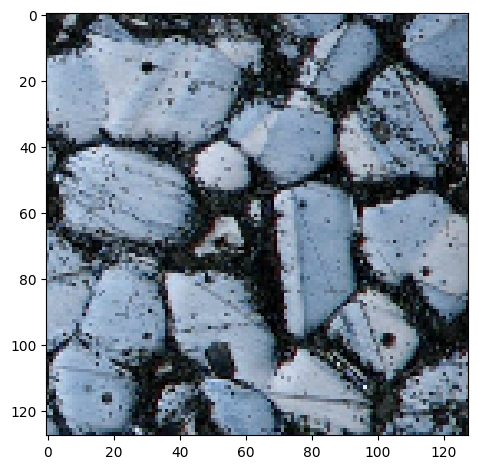

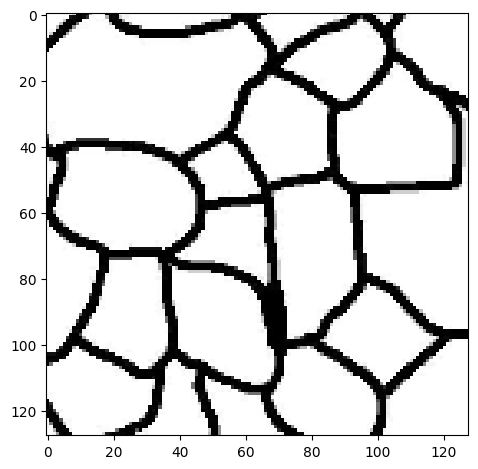

In [8]:
# example
image_x = random.randint(0, IMG_COUNT)
image_x
imshow(images[image_x])
plt.show()
imshow(masks[image_x])
plt.show()

# dataset splitting

In [9]:
# create the X and Y (input and output)

X_train = np.array(images)
Y_train = np.array(masks)
print(X_train.shape, Y_train.shape)
# change the Y to a boolean
Y_train = np.where(Y_train > 245, True, False)

(480, 128, 128, 3) (480, 128, 128, 3)


In [10]:
# careful to run this cell only once (otherwise shape changes)
X_train = np.transpose(X_train, (0, 3, 1 , 2))
Y_train = np.transpose(Y_train, (0, 3, 1 , 2))
print(X_train.shape, Y_train.shape)

(480, 3, 128, 128) (480, 3, 128, 128)


In [11]:
#convert the boolean where it insion s true (any of the 3 channels) to a (336, 128, 128, 1)
#basically reduce the 3 channel dimeRGB to just one boolean value

Y_t= np.any(Y_train, axis=1)
print(Y_t.shape)
Y_t = Y_t.reshape(IMG_COUNT, 1, 128, 128)
print(Y_t.shape)


(480, 128, 128)
(480, 1, 128, 128)


In [12]:
# prompt: Make Dataset from data

from torch.utils.data import Dataset

class GrainDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx]).float()
        mask = torch.from_numpy(self.masks[idx]).float()
        return image, mask

# Create the dataset
dataset = GrainDataset(X_train, Y_t)



Train dataset size: 384
Validation dataset size: 48
Test dataset size: 48


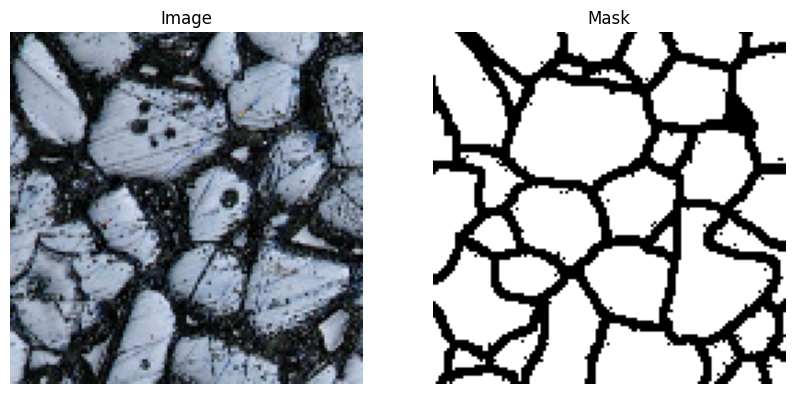

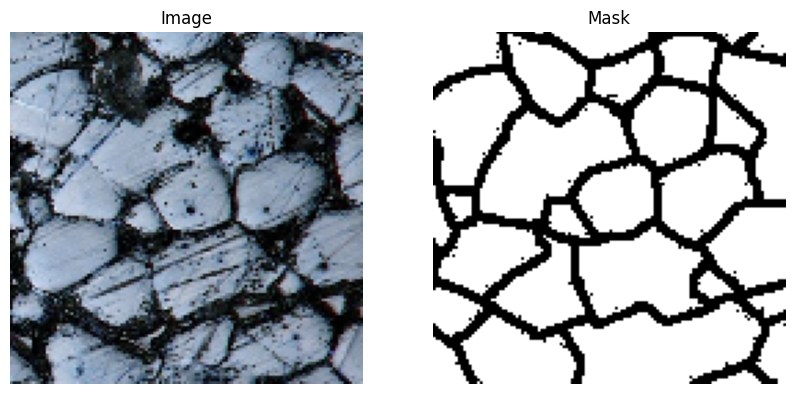

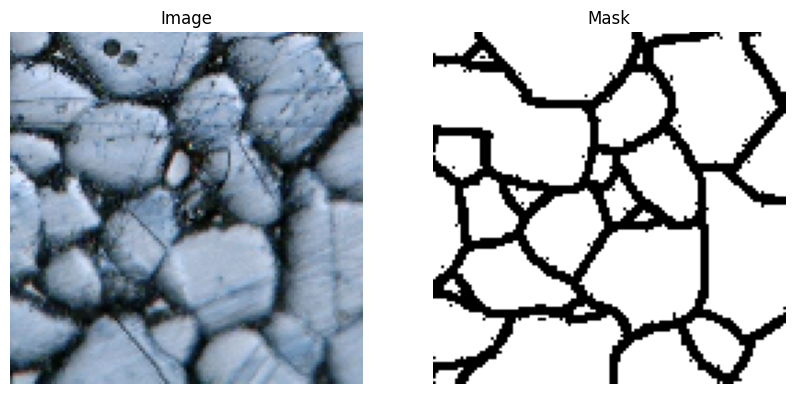

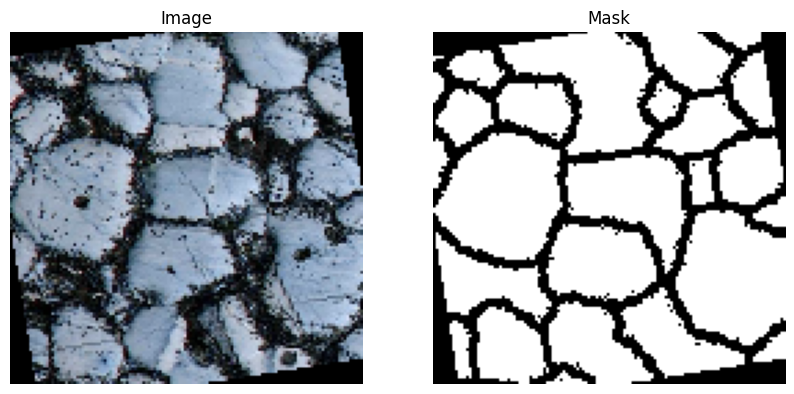

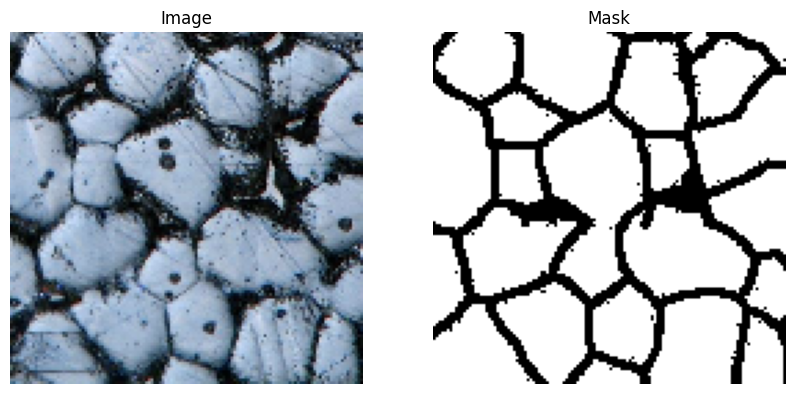

In [22]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchmetrics.functional import dice, jaccard_index
import random
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
import os

# Define the dataset class with transformations
class TrainGrainDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx].transpose(1, 2, 0).astype(np.uint8))
        mask = Image.fromarray(self.masks[idx].squeeze().astype(np.uint8))

        if self.transform:
            # Apply the same transformation to both image and mask
            seed = np.random.randint(2147483647)
            random.seed(seed)
            torch.manual_seed(seed)
            image = self.transform(image)

            random.seed(seed)
            torch.manual_seed(seed)
            mask = self.transform(mask)

        image = np.array(image).transpose(2, 0, 1)
        mask = np.array(mask).reshape(1, IMAGE_HEIGHT, IMAGE_WIDTH)

        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

# Define the dataset class without transformations
class ValTestGrainDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx].transpose(1, 2, 0).astype(np.uint8))
        mask = Image.fromarray(self.masks[idx].squeeze().astype(np.uint8))

        image = F.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
        mask = F.resize(mask, [IMAGE_HEIGHT, IMAGE_WIDTH])

        image = np.array(image).transpose(2, 0, 1)
        mask = np.array(mask).reshape(1, IMAGE_HEIGHT, IMAGE_WIDTH)

        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

# Define the transformations
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128

def transform(image):
    if random.random() > 0.5:
        image = F.hflip(image)
    if random.random() > 0.5:
        image = F.vflip(image)
    if random.random() > 0.5:
        angle = random.randint(-30, 30)
        image = F.rotate(image, angle)
    image = F.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    return image

# Split the data first
total_size = len(X_train)
train_size = int(0.80 * total_size)
val_size = int(0.10 * total_size)
test_size = total_size - train_size - val_size

# Random split the indices for images and masks
indices = list(range(total_size))
random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_images = X_train[train_indices]
val_images = X_train[val_indices]
test_images = X_train[test_indices]

train_masks = Y_t[train_indices]
val_masks = Y_t[val_indices]
test_masks = Y_t[test_indices]

# Create the datasets
train_dataset = TrainGrainDataset(train_images, train_masks, transform=transform)
val_dataset = ValTestGrainDataset(val_images, val_masks)
test_dataset = ValTestGrainDataset(test_images, test_masks)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Function to plot images and masks
def plot_image_and_mask(dataset, index):
    image, mask = dataset[index]
    image = image.numpy().transpose(1, 2, 0)  # Convert image from (C, H, W) to (H, W, C)
    mask = mask.numpy().squeeze()  # Remove single-dimensional entries from mask

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(image.astype(np.uint8))
    ax[0].set_title("Image")
    ax[0].axis('off')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Mask")
    ax[1].axis('off')

    plt.show()

# Plot a few images and masks from the train_dataset
for i in range(5):
    plot_image_and_mask(train_dataset, i)


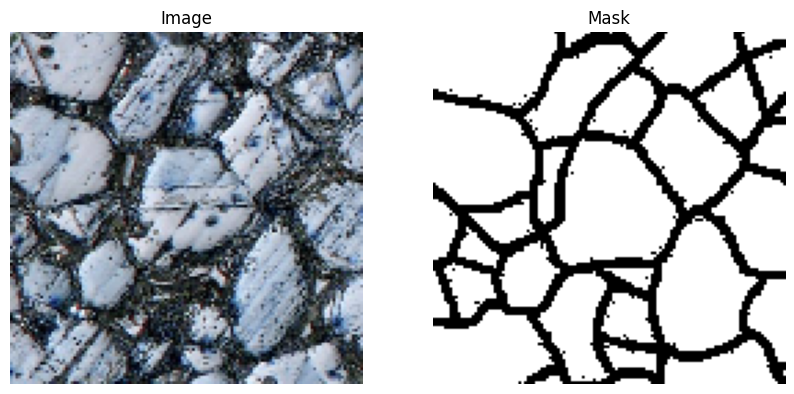

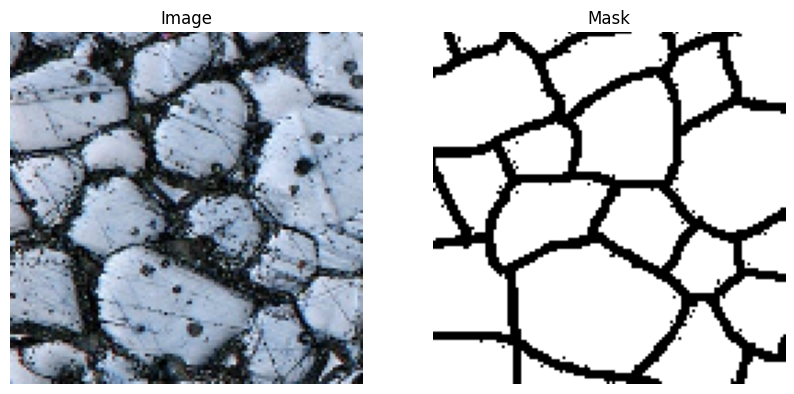

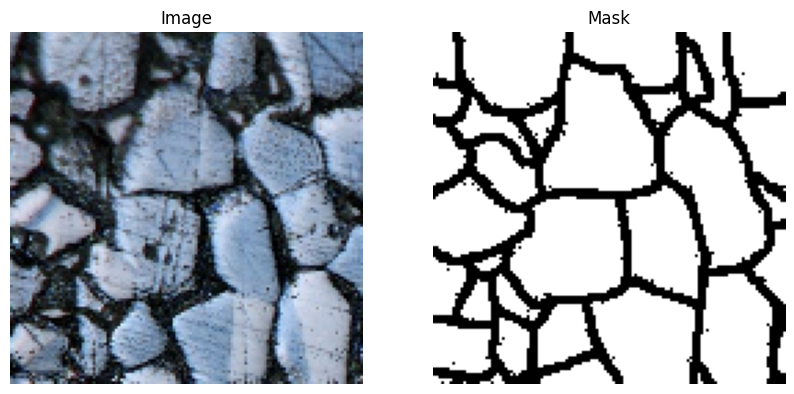

In [14]:
for i in range(3):
    plot_image_and_mask(test_dataset, i)

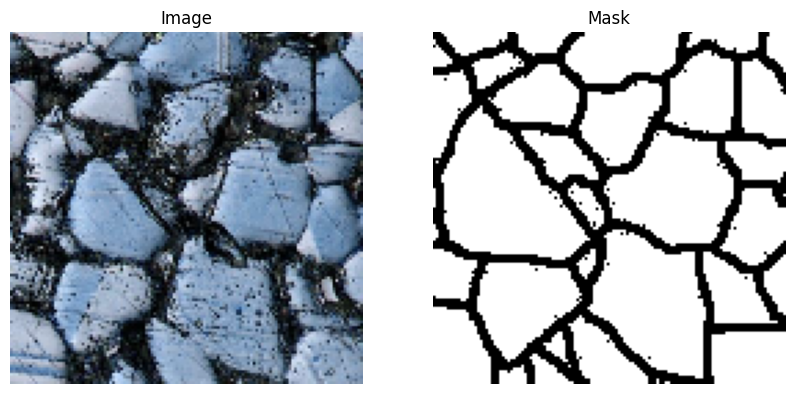

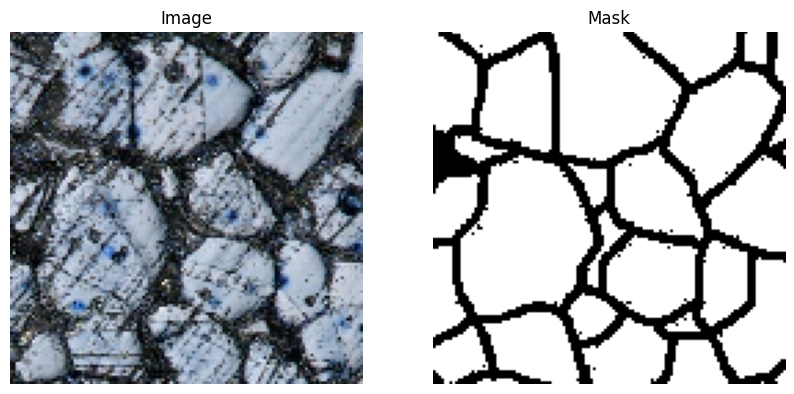

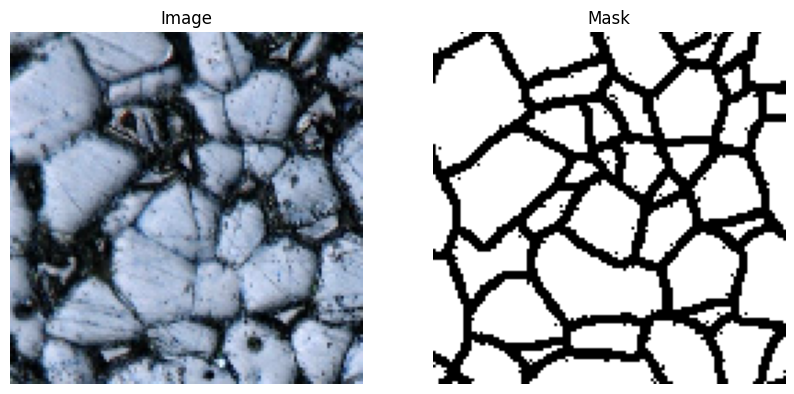

In [15]:
for i in range(3):
    plot_image_and_mask(val_dataset, i)

In [16]:
# # prompt: create train and validation dataset

# from torch.utils.data import random_split

# # Split the dataset into train and validation sets (80-10-10)
# train_size = int(0.80 * len(dataset))
# r = len(dataset) - train_size
# val_size = int(0.5 * r)
# test_size = int(0.5 * r)
# train_dataset, val_dataset,test_dataset = random_split(dataset, [train_size, val_size,test_size])



In [17]:
# print(f"Train : {train_size}")
# print(f"Val: {val_size}")
# print(f"Test: {test_size}")

Device Agnostic code

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Unet Attention

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Contraction path
        self.conv1 = self.contracting_block(in_channels, 16)
        self.conv2 = self.contracting_block(16, 32)
        self.conv3 = self.contracting_block(32, 64)
        self.conv4 = self.contracting_block(64, 128)
        self.conv5 = self.contracting_block(128, 256)


        # Expansive path
        self.upconv6 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv6 = self.expansive_block(256, 128)
        self.upconv7 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv7 = self.expansive_block(128, 64)
        self.upconv8 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv8 = self.expansive_block(64, 32)
        self.upconv9 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv9 = self.expansive_block(32, 16)

        # Output layer
        self.output_conv = nn.Conv2d(16, out_channels, kernel_size=1)

    def contracting_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
        )

    def expansive_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        # Contraction path
        mx_pool = nn.MaxPool2d(kernel_size=2)
        c1 = self.conv1(x)
        p1 = mx_pool(c1)
        c2 = self.conv2(p1)
        p2 = mx_pool(c2)
        c3 = self.conv3(p2)
        p3 = mx_pool(c3)
        c4 = self.conv4(p3)
        p4 = mx_pool(c4)
        c5 = self.conv5(p4)

        # Expansive path
        u6 = self.upconv6(c5)
        # print(c5.shape)
        # print(u6.shape, c4.shape) # for debugging
        u6 = torch.cat([u6, c4], dim=1)
        c6 = self.conv6(u6)
        u7 = self.upconv7(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.conv7(u7)
        u8 = self.upconv8(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.conv8(u8)
        u9 = self.upconv9(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.conv9(u9)

        # Output layer
        outputs = self.output_conv(c9)
        return torch.sigmoid(outputs)


# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(3, 1).to(device)

# Model summary
from torchsummary import summary
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3         [-1, 16, 128, 128]           2,320
              ReLU-4         [-1, 16, 128, 128]               0
           Dropout-5         [-1, 16, 128, 128]               0
            Conv2d-6           [-1, 32, 64, 64]           4,640
              ReLU-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           9,248
              ReLU-9           [-1, 32, 64, 64]               0
          Dropout-10           [-1, 32, 64, 64]               0
           Conv2d-11           [-1, 64, 32, 32]          18,496
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,928
             ReLU-14           [-1, 64,

In [20]:
class ModelCheckpoint:
    def __init__(self, checkpoint_path):
        self.checkpoint_path = checkpoint_path
        self.best_loss = float('inf')
        self.best_checkpoint_path = None

    def __call__(self, model, optimizer, epoch, train_loss, val_loss):
        if val_loss < self.best_loss:
            checkpoint_file = f"{self.checkpoint_path}_epoch_{epoch}.pt"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, checkpoint_file)
            print("Checkpoint saved")
            self.best_loss = val_loss
            self.best_checkpoint_path = checkpoint_file

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.val_loss_min = val_loss
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.val_loss_min = val_loss
            self.counter = 0

# Function to load the best checkpoint
def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return model, optimizer, checkpoint['epoch'], checkpoint['train_loss'], checkpoint['val_loss']


In [23]:
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from datetime import datetime
import os

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

# Define callbacks
checkpoint_path = f'/content/drive/MyDrive/465 Project/Unet Checkpoints/Unet-{datetime.now().strftime("%d%m%Y %H%M%S")}'
checkpointer = ModelCheckpoint(checkpoint_path)
early_stopping = EarlyStopping(patience=10, verbose=True)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    for inputs, targets in train_loader:
        # Move inputs and targets to the same device as the model
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs)  # Forward pass: compute the model output
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Update parameters
        train_loss += loss.item() * inputs.size(0)  # Aggregate the loss

    # After training batches, compute the average loss
    train_loss /= len(train_loader.dataset)

    # Evaluate the model if necessary, make sure to move evaluation data to the same device
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients for validation
        val_loss = 0.0
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Call the ModelCheckpoint callback
    checkpointer(model, optimizer, epoch, train_loss, val_loss)

    # Call early stopping
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the best checkpoint after training
if checkpointer.best_checkpoint_path:
    model, optimizer, epoch, train_loss, val_loss = load_checkpoint(checkpointer.best_checkpoint_path, model, optimizer)
    print(f'Loaded best checkpoint from epoch {epoch} with validation loss: {val_loss:.4f}')


Epoch [1/50], Train Loss: 0.4601, Val Loss: 0.3895
Checkpoint saved
Epoch [2/50], Train Loss: 0.3940, Val Loss: 0.3879
Checkpoint saved
Epoch [3/50], Train Loss: 0.3764, Val Loss: 0.3812
Checkpoint saved
Epoch [4/50], Train Loss: 0.3700, Val Loss: 0.3841
EarlyStopping counter: 1 out of 10
Epoch [5/50], Train Loss: 0.3658, Val Loss: 0.3878
EarlyStopping counter: 2 out of 10
Epoch [6/50], Train Loss: 0.3579, Val Loss: 0.3655
Checkpoint saved
Epoch [7/50], Train Loss: 0.3525, Val Loss: 0.3604
Checkpoint saved
Epoch [8/50], Train Loss: 0.3450, Val Loss: 0.3511
Checkpoint saved
Epoch [9/50], Train Loss: 0.3363, Val Loss: 0.3404
Checkpoint saved
Epoch [10/50], Train Loss: 0.3311, Val Loss: 0.3437
EarlyStopping counter: 1 out of 10
Epoch [11/50], Train Loss: 0.3273, Val Loss: 0.3366
Checkpoint saved
Epoch [12/50], Train Loss: 0.3204, Val Loss: 0.3294
Checkpoint saved
Epoch [13/50], Train Loss: 0.3179, Val Loss: 0.3268
Checkpoint saved
Epoch [14/50], Train Loss: 0.3164, Val Loss: 0.3265
Checkp

In [24]:
# current_checkpoint = torch.load(checkpoint_path)
# model.load_state_dict(current_checkpoint['model_state_dict'])
# model.eval()
# print(current_checkpoint['train_loss'],current_checkpoint['val_loss'])

## Display Result

# Scores

In [25]:
!pip install torchmetrics

## test set initialization

# Results

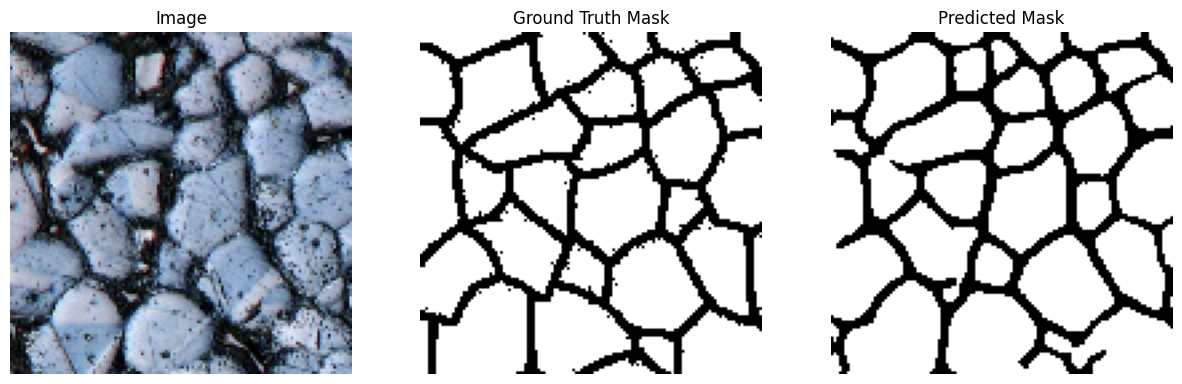

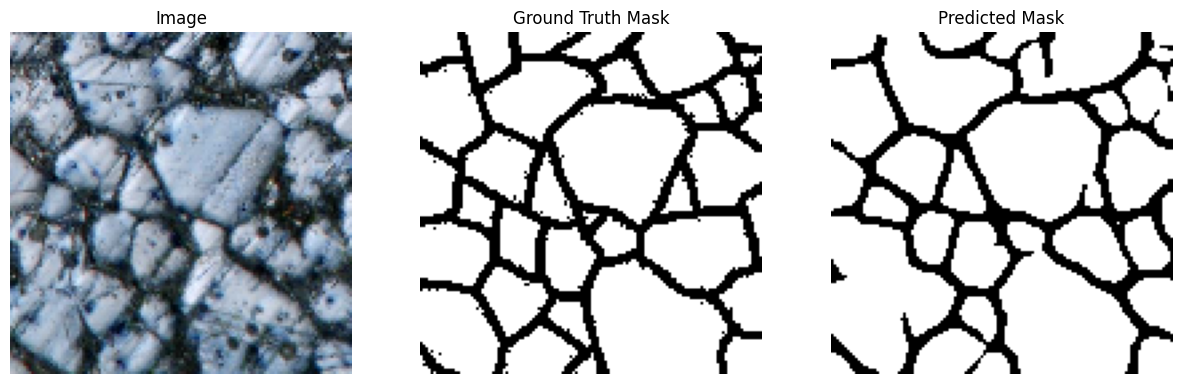

Total Number of samples: 48
Average Dice Score: 0.9093569107353687
Average Jaccard Index: 0.8341322913765907


In [26]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchmetrics.functional import dice, jaccard_index

# Initialize variables
total_jaccard_score = 0.0
total_dice_score = 0.0
total_num_samples = 0

# Assuming device is set (e.g., device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming model is defined and loaded
model.eval()  # Set the model to evaluation mode

def plot_image_mask_pred(image, mask, pred, index):
    image = image.numpy().transpose(1, 2, 0)  # Convert image from (C, H, W) to (H, W, C)
    mask = mask.numpy().squeeze()  # Remove single-dimensional entries from mask
    pred = pred.numpy().squeeze()  # Remove single-dimensional entries from prediction

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(image.astype(np.uint8))
    ax[0].set_title("Image")
    ax[0].axis('off')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Ground Truth Mask")
    ax[1].axis('off')

    ax[2].imshow(pred, cmap='gray')
    ax[2].set_title("Predicted Mask")
    ax[2].axis('off')

    plt.show()

for batch_idx, (images, masks) in enumerate(test_loader):
    batch_size = images.size(0)  # Get the actual batch size
    total_num_samples += batch_size

    with torch.no_grad():
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        preds = model(images)

        for ind in range(batch_size):
            pred_tensor = (preds[ind] > 0.5).float()
            gt_tensor = masks[ind].to(torch.int64)  # Convert mask tensor to integer tensor

            dice_score = dice(pred_tensor, gt_tensor)
            total_dice_score += dice_score.item()

            jaccard_score = jaccard_index(pred_tensor, gt_tensor, task='binary')
            total_jaccard_score += jaccard_score.item()

            # Plot the image, ground truth mask, and predicted mask for the first few samples
            if batch_idx * batch_size + ind < 2:  # Plot for the first few samples
                plot_image_mask_pred(images[ind].cpu(), masks[ind].cpu(), pred_tensor.cpu(), ind)

average_dice_score = total_dice_score / total_num_samples
average_jaccard_score = total_jaccard_score / total_num_samples

print(f"Total Number of samples: {total_num_samples}")
print(f"Average Dice Score: {average_dice_score}")
print(f"Average Jaccard Index: {average_jaccard_score}")
